# Test VQ-VAE performance on GEFS

VQ-VAE was trained on CCPA. This notebook tests its applicability on GEFS

In [1]:
import os
import sys
import time
import h5py
import numba as nb
import numpy as np
from glob import glob

# ------------------------------------------------------- #
# Turn-off warnings
import logging
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ------------------------------------------------------- #
# Turn-off tensoflow-specific warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# ------------------------------------------------------- #
# Import customized modules and settings
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu
import verif_utils as vu
import graph_utils as gu

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import importlib
# importlib.reload(mu)

In [4]:
# mu.set_seeds(888)

## Model imports

In [5]:
# Hyperparameters
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 4 # number of latent feature channels
activation = 'gelu' # activation function
num_embeddings = 128 #128 # number of the VQ codes

input_size = (224, 464, 1) # size of MRMS input
latent_size = (14, 29, latent_dim) # size of compressed latent features

drop_encode = True
drop_decode = True

model_name_encoder_load = model_dir+'models/VQ_VAE_encoder_stack1_tune0'
model_name_decoder_load = model_dir+'models/VQ_VAE_decoder_stack1_tune0'

'VQ_VAE_decoder_stack1_pretrain'

encoder = mu.VQ_VAE_encoder(input_size, filter_nums, latent_dim, num_embeddings, activation, drop_encode)
W_old = mu.dummy_loader(model_name_encoder_load)
encoder.set_weights(W_old)

decoder = mu.VQ_VAE_decoder(latent_size, filter_nums, activation, drop_decode)
W_old = mu.dummy_loader(model_name_decoder_load)
decoder.set_weights(W_old)

In [6]:
# Hyperparameters
input_size = (224, 464, 3)
filter_nums = [32, 64, 32]

model_name_load = model_dir+'models/VAE_refine_tune/'

decoder_refine = mu.VQ_VAE_refine_blocks(input_size, filter_nums)
W_old = mu.dummy_loader(model_name_load)
decoder_refine.set_weights(W_old)

In [11]:
iday0 = 0
iday1 = 10

In [8]:
# latent space feature size
latent_size = (14, 29, 4)

# output size
ccpa_shape = (224, 464)

# Lead time information
LEADs = np.arange(6, 144+6, 6) # forecast lead times
N_leads = len(LEADs)

# helper functions

def norm_precip(x):
    return np.log(0.1*x+1)

def norm_elev(x):
    return x / np.nanmax(x)
    
def to_precip(x):
    x[x<0] = 0
    return 10*(np.exp(x) - 1)

**Geographical & climatological info**

In [9]:
# land mask and the actual shape of the CCPA CONUS domain
with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    land_mask_CCPA = h5io['land_mask_CCPA'][...]
    elev_CCPA = h5io['elev_CCPA'][...]
    
land_mask = land_mask_CCPA == 1.0
ocean_mask = land_mask_CCPA == 0.0

elev_CCPA[ocean_mask] = 0
elev_CCPA[elev_CCPA<0] = 0
elev_CCPA = norm_elev(elev_CCPA) # <-- normalization

with h5py.File(camp_dir+'CCPA/CCPA_CDFs_2002_2019.hdf', 'r') as h5io:
    CCPA_CDFs = h5io['CCPA_CDFs'][...]
CCPA_CDFs_99 = norm_precip(CCPA_CDFs[99, ...]) # <-- normalization
CCPA_CDFs_99[ocean_mask, :] = 0

**Import data**

Raw GEFS operational members as input

In [12]:
with h5py.File(camp_dir+'GFS/GEFS_OPT_MEMBERS_2021.hdf', 'r') as h5io:
    GEFS_input = h5io['apcp'][iday0:iday1, ...]

N_days, _, EN, _, _ = GEFS_input.shape

# data pre-processing
GEFS_input[..., ocean_mask] = 0.0
GEFS_input = norm_precip(GEFS_input) # <-- normalization

VQ-VAE encode

In [13]:
GEFS_encode = np.empty((N_days, N_leads, EN)+latent_size)

for ilead in range(N_leads):
    print('encoding lead time ind: {}'.format(ilead))
    for ien in range(EN):
        GEFS_encode[:, ilead, ien, ...] = encoder.predict(GEFS_input[:, ilead, ien, ...], verbose=0)

encoding lead time ind: 0
encoding lead time ind: 1
encoding lead time ind: 2
encoding lead time ind: 3
encoding lead time ind: 4
encoding lead time ind: 5
encoding lead time ind: 6
encoding lead time ind: 7
encoding lead time ind: 8
encoding lead time ind: 9
encoding lead time ind: 10
encoding lead time ind: 11
encoding lead time ind: 12
encoding lead time ind: 13
encoding lead time ind: 14
encoding lead time ind: 15
encoding lead time ind: 16
encoding lead time ind: 17
encoding lead time ind: 18
encoding lead time ind: 19
encoding lead time ind: 20
encoding lead time ind: 21
encoding lead time ind: 22
encoding lead time ind: 23


VQ-VAE edcode

In [14]:
OUT_VAE = np.empty((N_days, N_leads, EN)+ccpa_shape)

for ilead, lead in enumerate(LEADs):
    print('decoding lead time ind: {}'.format(ilead))
    for ien in range(EN):
        OUT_VAE[:, ilead, ien, ...] = decoder.predict(GEFS_encode[:, ilead, ien, ...], verbose=0)[..., 0]
        
OUT_VAE[OUT_VAE<0] = 0
OUT_VAE[..., ocean_mask] = 0

decoding lead time ind: 0
decoding lead time ind: 1
decoding lead time ind: 2
decoding lead time ind: 3
decoding lead time ind: 4
decoding lead time ind: 5
decoding lead time ind: 6
decoding lead time ind: 7
decoding lead time ind: 8
decoding lead time ind: 9
decoding lead time ind: 10
decoding lead time ind: 11
decoding lead time ind: 12
decoding lead time ind: 13
decoding lead time ind: 14
decoding lead time ind: 15
decoding lead time ind: 16
decoding lead time ind: 17
decoding lead time ind: 18
decoding lead time ind: 19
decoding lead time ind: 20
decoding lead time ind: 21
decoding lead time ind: 22
decoding lead time ind: 23


In [15]:
OUT_refine = np.empty((N_days, N_leads, EN)+ccpa_shape)

input_ = np.empty((N_days,)+ccpa_shape+(3,))

for ilead, lead in enumerate(LEADs):
    print('refining lead time ind: {}'.format(ilead))
    # d_ = lead // 24
    # day = d + d_
    ind_hour = lead % 24
    ind_hour = int(ind_hour/6)
    CCPA_CDFs_99_ = CCPA_CDFs_99[..., ind_hour]
    
    for ien in range(EN):
        input_[..., 0] = OUT_VAE[:, ilead, ien, ...]
        input_[..., 1] = elev_CCPA[None, ...]
        input_[..., 2] = CCPA_CDFs_99_[None, ...]
        OUT_refine[:, ilead, ien, ...] = decoder_refine.predict(input_, verbose=0)[..., 0]

OUT_refine[OUT_refine<0] = 0
OUT_refine[..., ocean_mask] = 0

refining lead time ind: 0
refining lead time ind: 1
refining lead time ind: 2
refining lead time ind: 3
refining lead time ind: 4
refining lead time ind: 5
refining lead time ind: 6
refining lead time ind: 7
refining lead time ind: 8
refining lead time ind: 9
refining lead time ind: 10
refining lead time ind: 11
refining lead time ind: 12
refining lead time ind: 13
refining lead time ind: 14
refining lead time ind: 15
refining lead time ind: 16
refining lead time ind: 17
refining lead time ind: 18
refining lead time ind: 19
refining lead time ind: 20
refining lead time ind: 21
refining lead time ind: 22
refining lead time ind: 23


**Check results**

In [16]:
OUT_VAE_P = to_precip(OUT_VAE)
OUT_refine_P = to_precip(OUT_refine)

In [33]:
with h5py.File(camp_dir+'CCPA/CCPA_lead_y2021.hdf', 'r') as h5io:
    CCPA_true = h5io['CCPA_lead'][iday0:iday1, ...]

with h5py.File(camp_dir+'GFS/GEFS_OPT_MEMBERS_2021.hdf', 'r') as h5io:
    GEFS_input_verif = h5io['apcp'][iday0:iday1, ...]

In [20]:
OUT_VAE_P[..., ocean_mask] = np.nan
OUT_refine_P[..., ocean_mask] = np.nan
CCPA_true[..., ocean_mask] = np.nan
GEFS_input_verif[..., ocean_mask] = np.nan

In [34]:
print('Reconstrcut MAE: {} {}'.format(
    np.nanmean(np.abs(OUT_VAE_P - GEFS_input_verif)),
    np.nanmean(np.abs(OUT_refine_P - GEFS_input_verif))))

Reconstrcut MAE: 0.08078841442775865 0.08291343703749501


In [35]:
print('GEFS ens mean MAE: {}'.format(
    np.nanmean(np.abs(CCPA_true[:, :, None, ...] - GEFS_input_verif))))

GEFS ens mean MAE: 0.39734465257364127


Text(0.5, 1.0, '(f) CCPA')

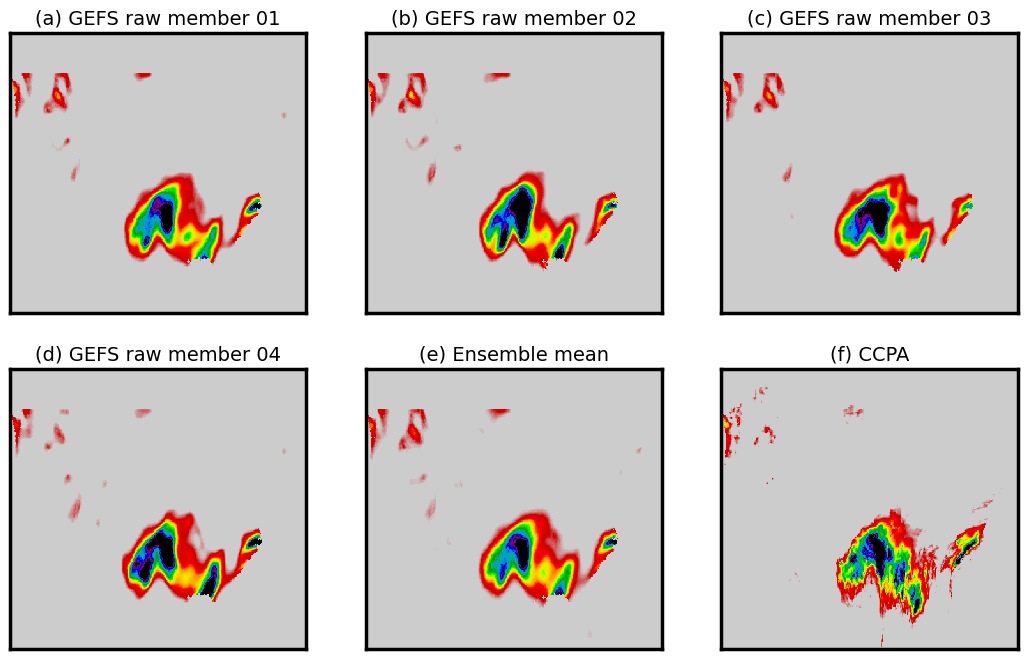

In [18]:
ilead = 0 # 00-06 forecasts
y_pred_plot = OUT_refine_P #to_precip(OUT_refine)
y_true_plot = CCPA_true

fig, AX = plt.subplots(2, 3, figsize=(13, 8))
for ax in AX.ravel():
    ax = gu.ax_decorate_box(ax)

AX[0][0].pcolormesh(y_pred_plot[0, ilead, 0, ...], vmin=0, vmax=20, cmap=plt.cm.nipy_spectral_r)
AX[0][0].set_title('(a) GEFS raw member 01', fontsize=14)

AX[0][1].pcolormesh(y_pred_plot[0, ilead, 1, ...], vmin=0, vmax=20, cmap=plt.cm.nipy_spectral_r)
AX[0][1].set_title('(b) GEFS raw member 02', fontsize=14)

AX[0][2].pcolormesh(y_pred_plot[0, ilead, 2, ...], vmin=0, vmax=20, cmap=plt.cm.nipy_spectral_r)
AX[0][2].set_title('(c) GEFS raw member 03', fontsize=14)

AX[1][0].pcolormesh(y_pred_plot[0, ilead, 3, ...], vmin=0, vmax=20, cmap=plt.cm.nipy_spectral_r)
AX[1][0].set_title('(d) GEFS raw member 04', fontsize=14)

AX[1][1].pcolormesh(np.mean(y_pred_plot[0, ilead, ...], axis=0), vmin=0, vmax=20, cmap=plt.cm.nipy_spectral_r)
AX[1][1].set_title('(e) Ensemble mean', fontsize=14)

AX[1][2].pcolormesh(y_true_plot[0, ilead, ...], vmin=0, vmax=20, cmap=plt.cm.nipy_spectral_r)
AX[1][2].set_title('(f) CCPA', fontsize=14)